In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef\
, precision_score, recall_score, f1_score
import time
import math

In [3]:
import os
import sys
new_path = "d:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/"
sys.path.append(new_path)
classpath = 'd:/Projects-my/ml/Ml-hse-final/ada-boost-implementations/code-python/adaboost_java/lib-adaboost.jar'

from ada_boost_standard_v1 import AdaBoostStandardClassifier_v1;
#from ada_boost_standard_v2 import AdaBoostStandardClassifier_v2;
from ada_boost_linear_v1 import AdaBoostLinear_v1;
from generation_utils import make_classification_normal, make_separable_labels;
from adaboost_java.ada_boost_java_v1 import AdaBoostJavaClassifier_v1;
from rademacher_utils import calc_rademacher_biclassifiers, calc_margin_loss

In [7]:
def draw_data_by_coord01(x_data, y_data, v_normal):
    plt.scatter(x_data[:, 0], x_data[:, 1], marker="o", c=y_data, s=10, edgecolor="k")
    y2_coord = -2*v_normal[0]/(v_normal[1] + 1e-10)
    plt.plot([-2,2], [-y2_coord, y2_coord], color='r')
    plt.show()


In [51]:
def calc_2classifiers_params_by_samples(samples, repeat_count = 5, test_share = 0.33):
    cnt = 0
    #marginsL, marginsJ, 
    classifiersL, classifiersJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, accuraciesL, accuraciesJ = [], [], [], []
    while cnt < repeat_count:
        from sklearn.datasets import make_classification

        X_data, _ = make_classification(n_samples=samples, n_features=5, n_informative=2
                                , n_redundant=2, n_clusters_per_class=2, shuffle=False)
        X_data, y_data, _ = make_separable_labels(X_data, rho=0.1)
        
        X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_share)
        #linear
        clf2000L = AdaBoostLinear_v1()
        _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
        separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
        if separated < 1:
            print("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            continue
        #ada boost
        clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
        result = clf2000J.fit(X_train2000, y_train2000)
        separated = accuracy_score(y_train2000, np.array(clf2000J.predict(X_train2000)))
        if separated < 1:
            print("Failed to separate, accuracy = {}".format(separated))
            continue
        X_trains.append(X_train2000)
        y_trains.append(y_train2000)
        classifiersL.append(clf2000L)
        classifiersJ.append(clf2000J)
        rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 10000))
        marginsL.append(clf2000L.get_margin())
        marginsJ.append(clf2000J.get_margin_l1(X_train2000))
        accuraciesL.append(accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
        accuraciesJ.append(accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
        cnt += 1
        
    return classifiersL, classifiersJ, rademachers, X_trains, y_trains, marginsL, marginsJ, accuraciesL, accuraciesJ


In [4]:
def calc_2classifiers_params(X_data, y_data, repeat_count = 5, test_share = 0.33):
    cnt = 0
    #marginsL, marginsJ, 
    classifiersL, classifiersJ, rademachers, X_trains, y_trains = [], [], [], [], []
    marginsL, marginsJ, accuraciesL, accuraciesJ = [], [], [], []
    while cnt < repeat_count:
        X_train2000, X_test2000, y_train2000, y_test2000 = train_test_split(X_data, y_data, test_size=test_share)
        #linear
        clf2000L = AdaBoostLinear_v1()
        _, _, _ = clf2000L.fit(X_train2000, y_train2000, allow_nonseparable=True)
        separated = accuracy_score(y_train2000, clf2000L.predict(X_train2000))
        if separated < 1:
            print("Failed to separate in linear algorithm, accuracy = {}".format(separated))
            continue
        #ada boost
        clf2000J = AdaBoostJavaClassifier_v1(path=classpath)
        result = clf2000J.fit(X_train2000, y_train2000)
        separated = accuracy_score(y_train2000, np.array(clf2000J.predict(X_train2000)))
        if separated < 1:
            print("Failed to separate, accuracy = {}".format(separated))
            continue
        X_trains.append(X_train2000)
        y_trains.append(y_train2000)
        classifiersL.append(clf2000L)
        classifiersJ.append(clf2000J)
        rademachers.append(clf2000J.calc_rademacher_biclassifiers(X_train2000, 10000))
        marginsL.append(clf2000L.get_margin())
        marginsJ.append(clf2000J.get_margin_l1(X_train2000))
        accuraciesL.append(accuracy_score(y_test2000, clf2000L.predict(X_test2000)))
        accuraciesJ.append(accuracy_score(y_test2000, clf2000J.predict(X_test2000)))
        cnt += 1
        
    return classifiersL, classifiersJ, rademachers, X_trains, y_trains, marginsL, marginsJ, accuraciesL, accuraciesJ


In [45]:
def draw_2classifiers_margin_bound(X_trains, y_trains, classifiersL, classifiersJ, rademachers, rho_vars):

    options = [
        ('r', 'Rightside value - linear algorithm'),
        ('g', 'Rightside value - ada boost algorithm')
    ]
    delta = 0.05

    #rho_vars = np.arange(0.2, 1, 0.05)
    avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))

    plt.ylabel('Parameter value')
    plt.xlabel('Rho value')
    cnt = 0

    for X_train, y_train, clfL, clfJ, rdm in zip(X_trains, y_trains, classifiersL, classifiersJ, rademachers):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        cnt += 1
        for rho_var in tqdm(rho_vars, total=len(rho_vars)):
            #print("Rdm={}, sample_size={}, rho={}".format(rdm, sample_size, rho_var))
            valueTail = 2*rdm/rho_var + 3*math.sqrt(math.log(2/delta)/(2*sample_size))
            valuesL.append(calc_margin_loss(X_train, y_train, clfL.predict_raw, rho_var) + valueTail)
            valuesJ.append(clfJ.calc_margin_loss(X_train, y_train, rho_var) + valueTail)

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(rademachers)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(rademachers)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.33, 1))

In [32]:
def draw_2classifiers_margin_loss(X_trains, y_trains, classifiersL, classifiersJ, rho_vars):
    options = [
        ('r', 'Rightside value - linear algorithm'),
        ('g', 'Rightside value - ada boost algorithm')
    ]

    #rho_vars = np.arange(0.0, 1, 0.05)
    avgL, avgJ = np.zeros(len(rho_vars)), np.zeros(len(rho_vars))
    start_time = time.time()

    plt.ylabel('Margin loss value')
    plt.xlabel('Rho value')
    cnt = 0

    for X_train, y_train, clfL, clfJ in zip(X_trains, y_trains, classifiersL, classifiersJ):
        sample_size = X_train.shape[0]
        valuesL, valuesJ = [], []
        cnt += 1
        for rho_var in tqdm(rho_vars, total=len(rho_vars)):
            valuesL.append(calc_margin_loss(X_train, y_train, clfL.predict_raw, rho_var))
            valuesJ.append(clfJ.calc_margin_loss(X_train, y_train, rho_var))

        avgL += np.array(valuesL)
        avgJ += np.array(valuesJ)
        plt.plot(rho_vars, valuesL, options[0][0] + ':', alpha=0.1)
        plt.plot(rho_vars, valuesJ, options[1][0] + ':', alpha=0.1)

    plt.plot(rho_vars, avgL / (1. * len(classifiersL)), options[0][0], linewidth=1.0, label=options[0][1])
    plt.plot(rho_vars, avgJ / (1. * len(classifiersL)), options[1][0], linewidth=1.0, label=options[1][1])
    dummy = plt.legend(bbox_to_anchor=(0.33, 1))


In [15]:
REPEAT_COUNT = 5
TEST_SIZE = 0.33

### Separable normaly distributed data, 2 features, train set - 1333, test set - 667

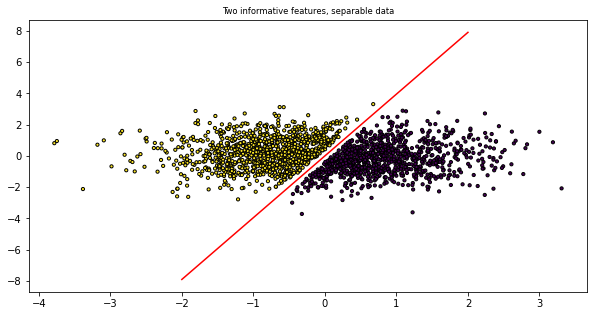

In [56]:
plt.figure(figsize=(10, 5))
plt.title("Two informative features, separable data", fontsize="small")
x_2000, y_2000, v_normal = make_classification_normal(2, 2000, rho=0.1)
draw_data_by_coord01(x_2000, y_2000, v_normal)

In [57]:
start = time.time()
cnt = 0
clfs2000L, clfs2000J, rads2000, X_trains2000, y_trains2000, mgns2000L, mgns2000J, acrcs2000L, acrcs2000J = \
    calc_2classifiers_params(x_2000, y_2000, repeat_count = REPEAT_COUNT, test_share = TEST_SIZE)
end = time.time()
print("Elapsed time: {}".format(end - start))

Elapsed time: 332.98998737335205


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:46<00:00,  2.91s/it]

time elapsed: 251.2307300567627


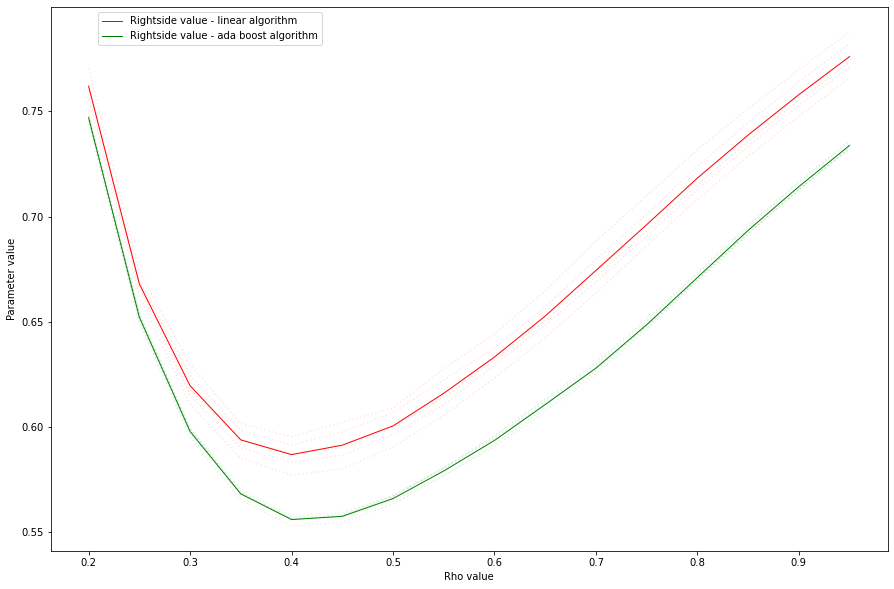

In [58]:
rho_vars = np.arange(0.2, 1, 0.05)
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains2000, y_trains2000, clfs2000L, clfs2000J, rads2000, rho_vars)
print('time elapsed:', (time.time() - start_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:58<00:00,  2.90s/it]

time elapsed: 291.86693930625916


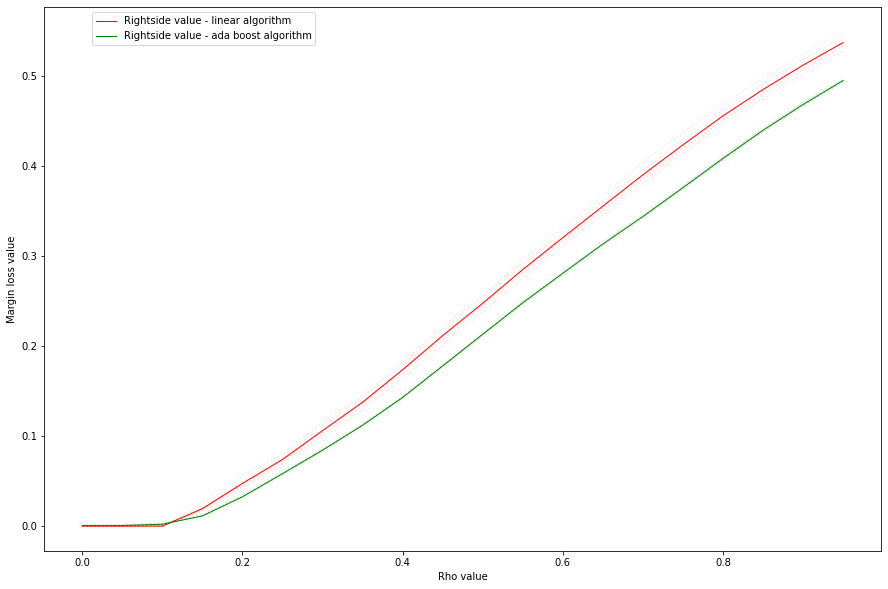

In [59]:
start_time = time.time()

rho_vars = np.arange(0.0, 1, 0.05)
plt.figure(figsize=(15,10))
draw_2classifiers_margin_loss(X_trains2000, y_trains2000, clfs2000L, clfs2000J, rho_vars)
print('time elapsed:', (time.time() - start_time))

In [64]:
vector2000_ones = np.ones(len(acrcs2000L))
errs2000L, errs2000J = vector2000_ones - acrcs2000L, vector2000_ones - acrcs2000J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(REPEAT_COUNT))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs2000L), np.std(errs2000L)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs2000J), np.std(errs2000J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns2000L), np.std(mgns2000L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns2000J), np.std(mgns2000J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rads2000), np.std(rads2000)))

IN A SERIES OF TESTS OF 5 EXPERIMENTS:
Linear emperical error: average-0.0003030303, std. deviation-0.0006060606
Ada boost emperical error: average-0.0015151515, std. deviation-0.0023472626
Linear average margin: average-0.1166666605, std. deviation-0.0068041306
Ada boost average margin: average-0.0798108816, std. deviation-0.0055962882
Rademacher emperical complexity calculated: average-0.0603164478, std. deviation-0.0001165278


In [ ]:
print(mgns2000L, mgns2000J)

### Separable normaly distributed data, 5 features, train set - 1333, test set - 667

In [52]:
clfs2000_2L, clfs2000_2J, rads2000_2, X_trains2000_2, y_trains2000_2, mgns2000_2L, mgns2000_2J, acrcs2000_2L, acrcs2000_2J = \
    calc_2classifiers_params_by_samples(2000, repeat_count = 5, test_share = 0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [02:13<00:00,  7.00s/it]

time elapsed: 687.0900509357452


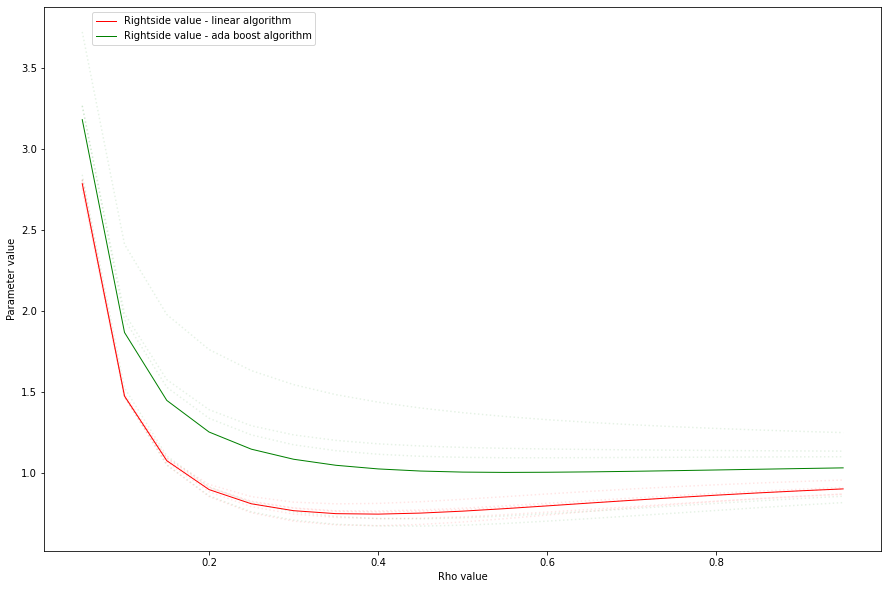

In [53]:
rho_vars = np.arange(0.05, 1, 0.05)
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains2000_2, y_trains2000_2, clfs2000_2L, clfs2000_2J, rads2000_2, rho_vars)
print('time elapsed:', (time.time() - start_time))

In [65]:
vector2000_2_ones = np.ones(len(acrcs2000_2L))
errs2000_2L, errs2000_2J = vector2000_2_ones - acrcs2000_2L, vector2000_2_ones - acrcs2000_2J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(1))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs2000_2L), np.std(errs2000_2L)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(errs2000_2J), np.std(errs2000_2J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns2000_2L), np.std(mgns2000_2L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(mgns2000_2J), np.std(mgns2000_2J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rads2000_2), np.std(rads2000_2)))

IN A SERIES OF TESTS OF 1 EXPERIMENTS:
Linear emperical error: average-0.0063636364, std. deviation-0.0038806814
Ada boost emperical error: average-0.0103030303, std. deviation-0.0053697107
Linear average margin: average-0.0751643813, std. deviation-0.0075425110
Ada boost average margin: average-0.0364077326, std. deviation-0.0152604108
Rademacher emperical complexity calculated: average-0.0668034627, std. deviation-0.0006528344


### Separable normaly distributed data, 2 features, train set - 13333, test set - 6667

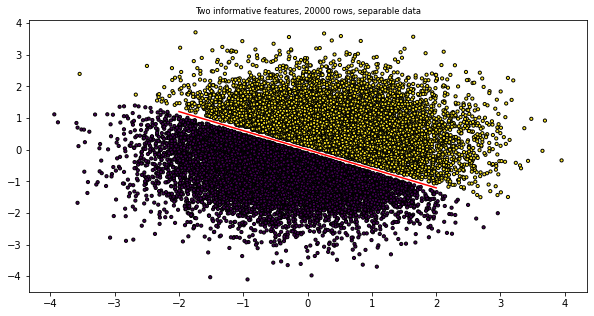

In [25]:
plt.figure(figsize=(10, 5))
plt.title("Two informative features, 20000 rows, separable data", fontsize="small")
x_20000, y_20000, v_normal = make_classification_normal(2, 20000, rho=0.1)
draw_data_by_coord01(x_20000, y_20000, v_normal)

In [26]:
start = time.time()
cnt = 0
clfs20000L, clfs20000J, rads20000, X_trains20000, y_trains20000, mgns20000L, mgns20000J, acrcs20000L, acrcs20000J = \
    calc_2classifiers_params(x_20000, y_20000, repeat_count = 1, test_share = TEST_SIZE)
end = time.time()
print("Elapsed time: {}".format(end - start))

Elapsed time: 9950.742216825485


100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:01:53<00:00, 195.47s/it]

time elapsed: 3713.908838033676


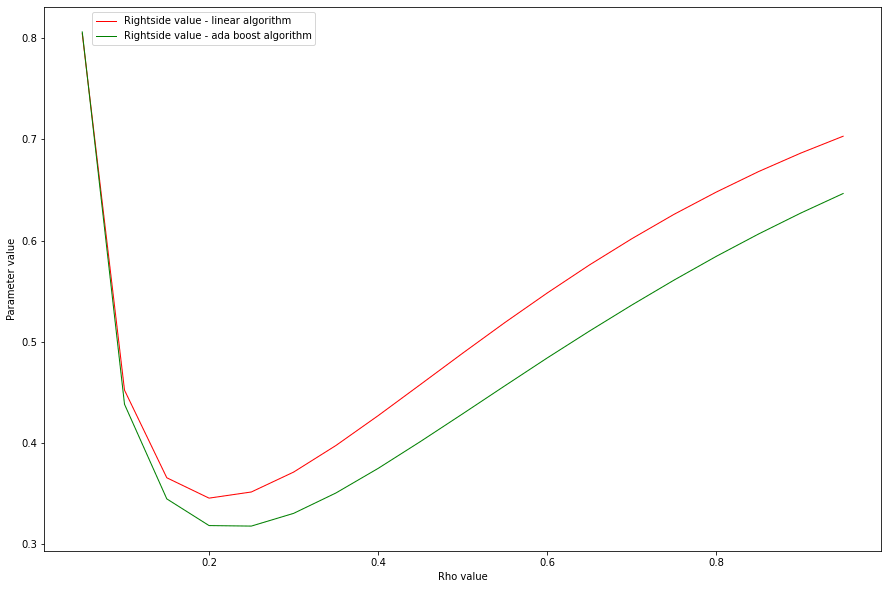

In [34]:
rho_vars = np.arange(0.05, 1, 0.05)
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains20000, y_trains20000, clfs20000L, clfs20000J, rads20000, rho_vars)
print('time elapsed:', (time.time() - start_time))

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:02:41<00:00, 197.98s/it]

time elapsed: 3761.555757045746


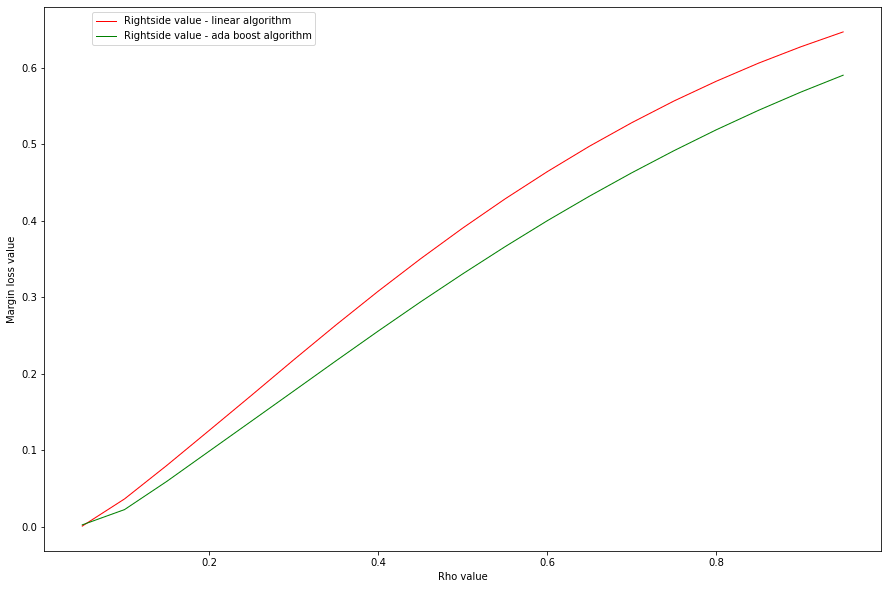

In [35]:
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_loss(X_trains20000, y_trains20000, clfs20000L, clfs20000J, rho_vars)
print('time elapsed:', (time.time() - start_time))

In [68]:
vector20000_ones = np.ones(len(acrcs20000L))
errs20000L, errs20000J = vector20000_ones - acrcs20000L, vector20000_ones - acrcs20000J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(1))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs20000L), np.std(errs20000J)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs20000J), np.std(errs20000J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns20000L), np.std(mgns20000L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns20000J), np.std(mgns20000J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rads20000), np.std(rads20000)))

IN A SERIES OF TESTS OF 1 EXPERIMENTS:
Linear emperical error: average-0.0001515152, std. deviation-0.0000000000
Ada boost emperical error: average-0.0000000000, std. deviation-0.0000000000
Linear average margin: average-0.0476190453, std. deviation-0.0000000000
Ada boost average margin: average-0.0107837291, std. deviation-0.0000000000
Rademacher emperical complexity calculated: average-0.0192164030, std. deviation-0.0000000000


Separable data, 10 clusters, 5 features, 2 informative, train set - 6667, test set - 3333

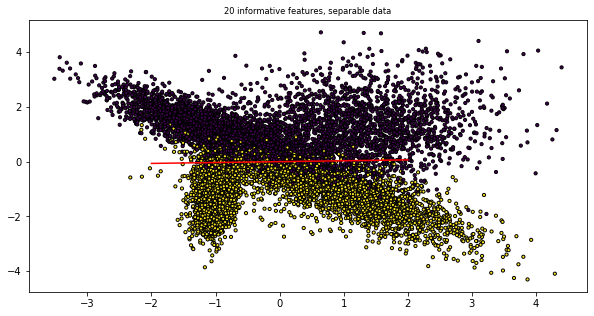

In [38]:
from sklearn.datasets import make_classification

x_10000, _ = make_classification(n_samples=10000, n_features=5,n_informative=2
                                , n_redundant=2, n_clusters_per_class=2, shuffle=False) #, random_state=0

plt.figure(figsize=(10, 5))
plt.title("20 informative features, separable data", fontsize="small")
x_10000, y_10000, v_normal = make_separable_labels(x_10000, rho=0.1)
draw_data_by_coord01(x_10000, y_10000, v_normal)


In [39]:
start = time.time()
cnt = 0
clfs10000L, clfs10000J, rads10000, X_trains10000, y_trains10000, mgns10000L, mgns10000J, acrcs10000L, acrcs10000J = \
    calc_2classifiers_params(x_10000, y_10000, repeat_count = 1, test_share = TEST_SIZE)
end = time.time()
print("Elapsed time: {}".format(end - start))

Elapsed time: 5826.921422958374


100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [39:18<00:00, 124.15s/it]

time elapsed: 2359.025635242462


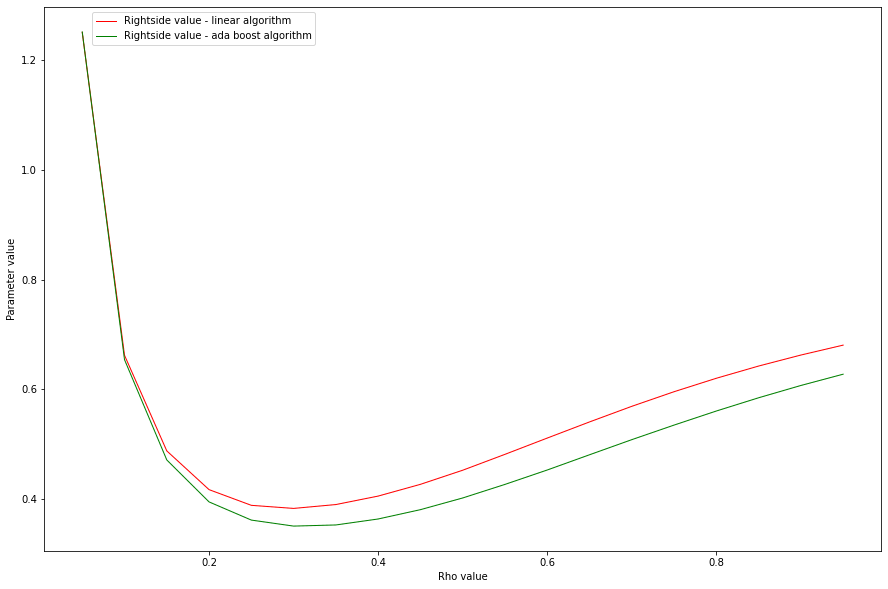

In [40]:
rho_vars = np.arange(0.05, 1, 0.05)
start_time = time.time()

plt.figure(figsize=(15,10))
draw_2classifiers_margin_bound(X_trains10000, y_trains10000, clfs10000L, clfs10000J, rads10000, rho_vars)
print('time elapsed:', (time.time() - start_time))

In [67]:
vector10000_ones = np.ones(len(acrcs10000L))
errs10000L, errs10000J = vector10000_ones - acrcs10000L, vector10000_ones - acrcs10000J
print("IN A SERIES OF TESTS OF {} EXPERIMENTS:".format(1))
print("Linear emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs10000L), np.std(errs10000L)))
print("Ada boost emperical error: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(errs10000J), np.std(errs10000J)))
print("Linear average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns10000L), np.std(mgns10000L)))
print("Ada boost average margin: average-{:1.10f}, std. deviation-{:1.10f}".format(np.average(mgns10000J), np.std(mgns10000J)))
print("Rademacher emperical complexity calculated: average-{:1.10f}, std. deviation-{:1.10f}"\
      .format(np.average(rads20000), np.std(rads20000)))

IN A SERIES OF TESTS OF 1 EXPERIMENTS:
Linear emperical error: average-0.0000000000, std. deviation-0.0000000000
Ada boost emperical error: average-0.0000000000, std. deviation-0.0000000000
Linear average margin: average-0.0649690441, std. deviation-0.0000000000
Ada boost average margin: average-0.0076990575, std. deviation-0.0000000000
Rademacher emperical complexity calculated: average-0.0192164030, std. deviation-0.0000000000
